[Kaai Kauwe](https://www.youtube.com/playlist?list=PLawAtY0TtS6u1o_AQNb5eWNXFn_UREl-B) has done the current analyzing without scaling the data and just with **RandomForestRegressor()** which the result was about **90%**. 

I did it with different type of machine learning and deep learning methods. Regression algorithms such as **Lasso(), ElasticNet(), Ridge(), LinearSVR()** on the **scaled** data have lead to accuracy of about **96%**.

We will start by looking at inorganic heat capacity data taken from the NIST: [JANAF tables](https://janaf.nist.gov/). We will need to download this data into the folder that contains this python file. The heat capacity data can be grabbed [here](https://drive.google.com/open?id=1gAeESVOezMg2NJ_86akryFQBq9vImCd8)

This dataset contains heat capacity data for almost 300 inorganic compounds. We will use this dataset show how formula features are generated, and talk about some data processing choices.

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style='whitegrid', color_codes=True)
import scipy
from scipy import stats
from scipy.stats import norm
import pymatgen as mg
import pydot

In [141]:
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

In [142]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import plot_model

# 1: Import the Data

- get material data and handle material data using the pandas package
- visualizing data with the seaborn package
- add formula based features to the data

In [5]:
# Inorganic heat_capacity data
heat_capacity = pd.read_csv('heat_capacity_298K.csv')
heat_capacity.head()

,FORMULA,PROPERTY: Heat Capacity (J/mol K)
0,Al1,24.209
1,Al1Br3,100.578
2,Al1Cl1O1,56.902
3,Al1Cl3,91.128
4,Al1Cl4K1,156.482


In [6]:
heat_capacity.shape

(276, 2)

In [7]:
heat_capacity.dtypes

FORMULA                               object
PROPERTY: Heat Capacity (J/mol K)    float64
dtype: object

In [8]:
heat_capacity.isnull().sum()

FORMULA                              0
PROPERTY: Heat Capacity (J/mol K)    0
dtype: int64

In [9]:
heat_capacity.FORMULA.unique()

array(['Al1', 'Al1Br3', 'Al1Cl1O1', 'Al1Cl3', 'Al1Cl4K1', 'Al1Cl4Na1',
       'Al1Cl6K3', 'Al1Cl6Na3', 'Al1F3', 'Al1F6K3', 'Al1F6Li3',
       'Al1F6Na3', 'Al1H4Li1', 'Al1I3', 'Al1Li1O2', 'Al1N1', 'Al1Na1O2',
       'Al2Be1O4', 'Al2Cl9K3', 'Al2Mg1O4', 'Al2O3', 'B1', 'B1F4K1',
       'B1H1O2', 'B1H3O3', 'B1H4K1', 'B1H4Li1', 'B1H4Na1', 'B1K1O2',
       'B1Li1O2', 'B1N1', 'B1Na1O2', 'B1Ti1', 'B2Be3O6', 'B2H4O4',
       'B2Mg1', 'B2O3', 'Ba1', 'Ba1Br2', 'Ba1Cl2', 'Ba1F2', 'Ba1H2O2',
       'Ba1I2', 'Ba1O1', 'Ba1S1', 'Be1', 'Be1Br2', 'Be1Cl2', 'Be1F2',
       'Be1F3Li1', 'Be1F4Li2', 'Be1H2O2', 'Be1I2', 'Be1O1', 'Be1O4S1',
       'Be1O4W1', 'Be1S1', 'Be2O4Si1', 'Be3N2', 'Br1H4N1', 'Br1K1',
       'Br1Na1', 'Br2Pb1', 'Br2Sr1', 'Br3Ti1', 'Br3Zr1', 'Br4Ti1',
       'C0.98Nb1', 'C1B4', 'C1Be2', 'C1Cu1N1', 'C1K2O3', 'C1Li2O3',
       'C1Mg1O3', 'C1Na2O3', 'Ca1', 'Ca1Cl2', 'Ca1F2', 'Ca1H2O2', 'Ca1I2',
       'Ca1O1', 'Ca1S1', 'Cl1Cs1', 'Cl1Cu1', 'Cl1H4N1', 'Cl1H4N1O4',
       'Cl1I1', 'Cl1K1', 'Cl1

In [10]:
heat_capacity['PROPERTY: Heat Capacity (J/mol K)'].describe()

count    276.000000
mean      80.736888
std       46.246709
min       11.315000
25%       49.810000
50%       73.772000
75%      101.679500
max      337.230000
Name: PROPERTY: Heat Capacity (J/mol K), dtype: float64

# 2: Look at the Data

Now we look at the **distribution** of the data. Usually, **machine_learning** algorithms are working properly on **normalized** distributed data!

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


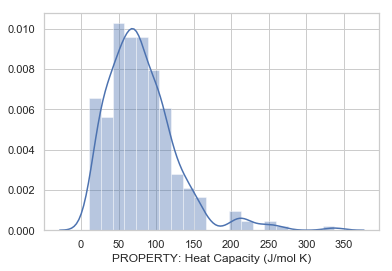

In [11]:
# Make a graph to visualize the distribution of the heat_capacity
sns.distplot(heat_capacity['PROPERTY: Heat Capacity (J/mol K)'])

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


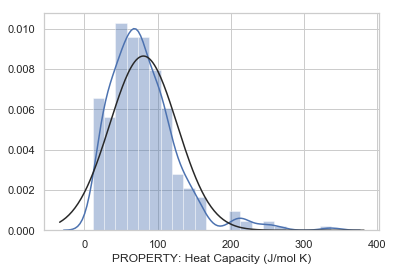

In [12]:
# Normal distribution of heat_capacity
sns.distplot(heat_capacity['PROPERTY: Heat Capacity (J/mol K)'], fit=norm)

((array([-2.80597209, -2.50700419, -2.33750901, -2.21661313, -2.12142152,
         -2.04228618, -1.97419162, -1.91418309, -1.86036734, -1.81145546,
         -1.76652874, -1.72490835, -1.68607789, -1.64963504, -1.61525996,
         -1.58269404, -1.55172506, -1.52217663, -1.49390047, -1.4667707 ,
         -1.4406795 , -1.41553377, -1.39125254, -1.36776493, -1.34500855,
         -1.32292813, -1.3014745 , -1.28060372, -1.26027632, -1.24045674,
         -1.2211128 , -1.20221531, -1.18373766, -1.16565557, -1.14794677,
         -1.13059084, -1.11356896, -1.09686375, -1.08045916, -1.0643403 ,
         -1.04849332, -1.03290538, -1.01756445, -1.00245934, -0.98757956,
         -0.97291528, -0.9584573 , -0.94419694, -0.93012604, -0.91623694,
         -0.90252238, -0.8889755 , -0.87558984, -0.86235925, -0.84927792,
         -0.83634033, -0.82354123, -0.81087565, -0.79833883, -0.78592625,
         -0.77363359, -0.76145674, -0.74939176, -0.73743489, -0.72558254,
         -0.71383125, -0.70217771, -0.

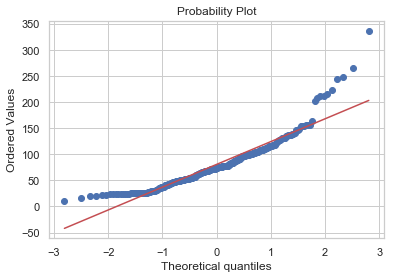

In [13]:
# Calculate quantiles for a probability plot, and optionally show the plot
stats.probplot(heat_capacity['PROPERTY: Heat Capacity (J/mol K)'], plot=plt)

Although it is not perfect, we can confime that the data is close to a **normal distribution**. Perfectly normal data would lie on the **red** line of the probability plot. A more robust approach could normalize the data to help improve algorithm performance. 

To briefly illustrate this, lets consider a **log transformation**, which looks appropriate for the distribution of heat capacity values.

In [14]:
# Log transformation often can help to normalize the data
log_heat_capacity = np.log(heat_capacity['PROPERTY: Heat Capacity (J/mol K)'])

C:\Users\alisa\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


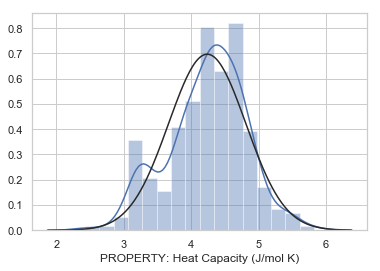

In [15]:
sns.distplot(log_heat_capacity, fit=norm)

((array([-2.80597209, -2.50700419, -2.33750901, -2.21661313, -2.12142152,
         -2.04228618, -1.97419162, -1.91418309, -1.86036734, -1.81145546,
         -1.76652874, -1.72490835, -1.68607789, -1.64963504, -1.61525996,
         -1.58269404, -1.55172506, -1.52217663, -1.49390047, -1.4667707 ,
         -1.4406795 , -1.41553377, -1.39125254, -1.36776493, -1.34500855,
         -1.32292813, -1.3014745 , -1.28060372, -1.26027632, -1.24045674,
         -1.2211128 , -1.20221531, -1.18373766, -1.16565557, -1.14794677,
         -1.13059084, -1.11356896, -1.09686375, -1.08045916, -1.0643403 ,
         -1.04849332, -1.03290538, -1.01756445, -1.00245934, -0.98757956,
         -0.97291528, -0.9584573 , -0.94419694, -0.93012604, -0.91623694,
         -0.90252238, -0.8889755 , -0.87558984, -0.86235925, -0.84927792,
         -0.83634033, -0.82354123, -0.81087565, -0.79833883, -0.78592625,
         -0.77363359, -0.76145674, -0.74939176, -0.73743489, -0.72558254,
         -0.71383125, -0.70217771, -0.

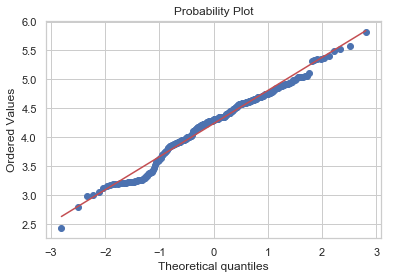

In [16]:
stats.probplot(log_heat_capacity, plot=plt)

# 3: Make Feature Vector from the Formula

In [17]:
# Importing the features of the elemnts
element_data = pd.read_csv('simple_element_properties.csv')
element_data.head()

,Symbol,Atomic_Number,Atomic_Weight,Period,group,families,Mendele_Number,l_quantum_number,Atomic_Radus,Miracle_Radius_[pm],...,nws(e/au3),volume(10-6m3),Work_function,G,abs_valence,Nearest_Neighbor_Distance(pm),Critical_Temperature,Low_Temp_Debye(K),High_Temp_Debye(K),Atomic_Concentration(1e-23_cm-3)
0,H,1,1.01,1,1,7,92,0,0.53,NaN,...,3.38,1.7,NaN,NaN,1,NaN,33.00,122.0,0.0,NaN
1,He,2,4.00,1,18,9,98,0,0.31,NaN,...,NaN,NaN,NaN,NaN,2,NaN,5.19,NaN,NaN,NaN
2,Li,3,6.94,2,1,1,1,0,1.67,152.0,...,0.94,13.0,2.93,4.2,1,302.0,3223.00,344.0,448.0,4.7
3,Be,4,9.01,2,2,2,67,0,1.12,112.0,...,4.66,4.9,4.98,132.6,2,222.0,13000.00,1481.0,1031.0,12.1
4,B,5,10.81,2,13,6,72,1,0.87,88.0,...,5.36,4.7,4.45,177.0,1,NaN,3284.00,1480.0,1362.0,13.0


In [18]:
# Changing index to 'symbol'
element_data = pd.read_csv('simple_element_properties.csv', index_col=0)
element_data.head()

,Atomic_Number,Atomic_Weight,Period,group,families,Mendele_Number,l_quantum_number,Atomic_Radus,Miracle_Radius_[pm],Covalent_Radius,...,nws(e/au3),volume(10-6m3),Work_function,G,abs_valence,Nearest_Neighbor_Distance(pm),Critical_Temperature,Low_Temp_Debye(K),High_Temp_Debye(K),Atomic_Concentration(1e-23_cm-3)
Symbol,,,,,,,,,,,,,,,,,,,,,
H,1,1.01,1,1,7,92,0,0.53,NaN,0.37,...,3.38,1.7,NaN,NaN,1,NaN,33.00,122.0,0.0,NaN
He,2,4.00,1,18,9,98,0,0.31,NaN,0.32,...,NaN,NaN,NaN,NaN,2,NaN,5.19,NaN,NaN,NaN
Li,3,6.94,2,1,1,1,0,1.67,152.0,1.34,...,0.94,13.0,2.93,4.2,1,302.0,3223.00,344.0,448.0,4.7
Be,4,9.01,2,2,2,67,0,1.12,112.0,0.90,...,4.66,4.9,4.98,132.6,2,222.0,13000.00,1481.0,1031.0,12.1
B,5,10.81,2,13,6,72,1,0.87,88.0,0.82,...,5.36,4.7,4.45,177.0,1,NaN,3284.00,1480.0,1362.0,13.0


In [19]:
element_data.shape

(85, 57)

In [20]:
element_data.columns

Index(['Atomic_Number', 'Atomic_Weight', 'Period', 'group', 'families',
       'Mendele_Number', 'l_quantum_number', 'Atomic_Radus',
       'Miracle_Radius_[pm]', 'Covalent_Radius', 'Zunger_radii_sum',
       'ionic_radius', 'Orbital_Radius(pm)', 'crystal_radius',
       'Pauling_Electronegativity', 'MB_electonegativity',
       'Nagle_electonegativity', 'Pearson_abs_electonegativity',
       'Gordy_electonegativity', 'Mulliken_EN',
       'Allred-Rockow_electronegativity', 'metallic_valence',
       'number_of_valence_electrons', 'gilmor_number_of_valence_electron',
       'valence_s', 'valence_p', 'valence_d', 'valence_f',
       'Number_of_unfilled_s_valence_electrons',
       'Number_of_unfilled_p_valence_electrons',
       'Number_of_unfilled_d_valence_electrons',
       'Number_of_unfilled_f_valence_electrons', 'outer_shell_electrons',
       '1st_ionization_potential_(kJ/mol)', 'polarizability(A^3)',
       'Melting_point_(K)', 'Boiling_Point_(K)', 'Molar_Denstiy_(mol/ml)',
    

In [21]:
def get_features(formula):
#     keys = []
    '''
    Input
    ----------
    formula: string
        put a valid chemical fomula as a sting. Example( 'NaCl')

    Output
    ----------
    features: np.array()
        This is an 1x252 length array containing feature values for use in the
        machine learning model.
    '''
    try:
        fractional_composition = mg.Composition(formula).fractional_composition.as_dict()
        element_composition = mg.Composition(formula).element_composition.as_dict()
        avg_feature = np.zeros(len(element_data.iloc[0]))
        sum_feature = np.zeros(len(element_data.iloc[0]))
        for key in fractional_composition:
            try:
                avg_feature += element_data.loc[key].values * fractional_composition[key]
                sum_feature += element_data.loc[key].values * element_composition[key]
#                 keys.append(key)
            except:
                print('The element:', key, 'is not currently supported in our database')
                return np.array([np.nan]*len(element_data.iloc[0])*4)
        var_feature = element_data.loc[list(fractional_composition.keys())].var()
        range_feature = element_data.loc[list(fractional_composition.keys())].max()-element_data.loc[list(fractional_composition.keys())].min()

        features = pd.DataFrame(np.concatenate([avg_feature, sum_feature, np.array(var_feature), np.array(range_feature)]))
        features = np.concatenate([avg_feature, sum_feature, np.array(var_feature), np.array(range_feature)])
        return features.transpose()
    except:
        print('There was and error with the Formula: '+ formula + ', this is a general exception with an unkown error')
        return [np.nan]*len(element_data.iloc[0])*4

In [22]:
# Lets examine the formula 'NaCl'
example_vector = get_features('NaCl')
type(example_vector)

numpy.ndarray

In [23]:
example_vector.shape

(228,)

In [24]:
example_vector

array([1.40000000e+01, 2.92200000e+01, 3.00000000e+00, 9.00000000e+00,
       4.50000000e+00, 4.80000000e+01, 5.00000000e-01, 1.34500000e+00,
                  nan, 1.26500000e+00, 1.83000000e+00, 1.40000000e+00,
       1.21900000e+02, 1.41500000e+00, 2.04500000e+00, 1.93500000e+00,
       1.88500000e+00, 5.57500000e+00, 4.69000000e+00, 5.57500000e+00,
       1.87000000e+00, 5.00000000e-01, 4.00000000e+00, 4.00000000e+00,
       1.50000000e+00, 2.50000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.00000000e-01, 3.50000000e+00, 1.00000000e+01, 1.40000000e+01,
       4.00000000e+00, 8.73500000e+02, 1.29000000e+01, 2.71550000e+02,
       6.97350000e+02, 2.00000000e-02, 4.85000000e-01, 2.26500000e+01,
       8.55000000e-01, 2.91500000e+00, 5.35800000e+01, 7.05050000e+01,
       1.15000000e+02, 1.25500000e+00, 3.95000000e+00,            nan,
                  nan,            nan,            nan, 3.00000000e+00,
       2.84000000e+02, 1.49498000e+03,            nan,            nan,
      

Now lets create a **feature vector** for each entry in our heat capacity data.

In [25]:
# Create the empty lists of features and targets
features = []
targets = []

for formula, target in zip(heat_capacity['FORMULA'],heat_capacity['PROPERTY: Heat Capacity (J/mol K)']):
    features.append(get_features(formula))
    targets.append(target)

In [26]:
print(len(features))
print(len(features[0]))

276
228


In [27]:
len(targets)

276

In [28]:
# Create a DataFrame of features
df_features = pd.DataFrame(features)
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,13.000000,26.980000,3.000000,13.000000,5.000000,73.000000,1.000000,1.180000,141.0,1.180000,...,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00
1,29.500000,66.670000,3.750000,16.000000,7.250000,89.500000,1.000000,1.000000,NaN,1.150000,...,0.00,0.00,0.00,0.0,4.0,0.0,7966.00,0.0,0.0,3.66
2,12.666667,26.143333,2.666667,15.333333,6.666667,84.666667,1.000000,0.816667,NaN,0.966667,...,0.00,0.00,0.00,0.0,4.0,84.0,8395.42,0.0,0.0,0.00
3,16.000000,33.332500,3.000000,16.000000,7.250000,88.750000,1.000000,0.887500,NaN,1.037500,...,0.00,0.00,0.00,0.0,4.0,84.0,8133.04,0.0,0.0,0.00
4,16.666667,34.646667,3.166667,13.666667,6.333333,75.333333,0.833333,1.128333,NaN,1.183333,...,2.43,35.63,1.97,24.7,4.0,251.0,8133.04,341.9,290.0,4.62


In [29]:
print(df_features.shape)

(276, 228)


In [30]:
# Create a Series of targets
ser_targets = pd.Series(targets)
ser_targets.head()

0     24.209
1    100.578
2     56.902
3     91.128
4    156.482
dtype: float64

In [31]:
ser_targets.shape

(276,)

# 4: Cleaning the Data

In [32]:
# Searching for missing values in Data
sum(df_features.isnull().sum())

6789

* As we see there are **6789 missing values** in our DataFrame!

In [33]:
# Search for missing values in target
ser_targets.isnull().sum()

0

* We will **drop** formula which we could not convert into feature vectors. 
* We will also **replace** missing feature values with the average values in the dataset.

In [34]:
# If all features of a formula in the row are 'NaN' it should be droped!
df_features.dropna(inplace=True, how='all')
ser_targets = ser_targets.loc[df_features.index]

In [35]:
df_features.reset_index(drop=True, inplace=True)
ser_targets.reset_index(drop=True, inplace=True)

In [36]:
df_features.shape

(276, 228)

In [37]:
ser_targets.shape

(276,)

In [38]:
# Finding the average of each specific columns!
cols = df_features.columns
mean_values = df_features[cols].mean()
mean_values.head()

0    20.311513
1    45.772630
2     3.104065
3    10.939028
4     5.532194
dtype: float64

In [39]:
# Filling the missing values with 'mean_values'
df_features[cols] = df_features[cols].fillna(mean_values.iloc[0])
sum(df_features.isnull().sum())

0

* All those **6789 missing values** are replaced with the mean value of their own column!

# 5: Standardizing Data

* Scikit-learn models assume normally distributed	data 
* example: **Log Normalization** and **Feature Scaling**
* Applied to continuous numerical data
* Model in linear space
* Dataset features have	high variance
* Dataset features are continuous and on different scales
* Linearity	assumptions

### 5-1: Log Normalization

In [40]:
# It is difficult to see the variance of all the features, so i will postepone this command!

### 5-2: Scaling

* Features on different scales
* Model with linear characteristics
* Center features around 0 and transform to unit variance 
* Transforms to approximately normal distribution

In [41]:
# Before scaling
df_features.var().head()

0     225.795393
1    1397.418693
2       1.038715
3      13.723228
4       1.489164
dtype: float64

In [42]:
# After scaling
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
df_scaled.var().head()

0    1.003636
1    1.003636
2    1.003636
3    1.003636
4    1.003636
dtype: float64

# 6: Feature Engineering

* Creation of new feature(s) based on existing features
* Insight into relationships between features
* Extract and expand data 

### 6-1: Engineering Categorical Variables

* Encoding binary variables (pandas)
* Encoding binary variables (scikit-learn)
* One-hot coding

### 6-2: Engineering Numerical Variables

* Aggregate Statistics
* Dates

# 7: Feature Selection

* Selecting features to be used for modeling
* No creation of the new features

# 8: Dimensionality Reduction

* Principle Components Analysis (PCA)
* Linear transformation to uncorrelated space
* Capture as much variance as possible in each component

In [43]:
# Using PCA to reduce dimentionality
pca = PCA()
df_pca = pca.fit_transform(df_scaled)
df_pca

array([[ 1.86982825e+01, -1.54503699e+00,  3.03700265e+00, ...,
        -2.98650922e-16,  9.55353844e-17, -8.05227041e-17],
       [-1.25053743e+00, -1.28647446e+00, -3.73590858e+00, ...,
         3.31373947e-16, -8.86363180e-17,  1.18214701e-16],
       [-1.73793169e+00,  9.31941500e-01, -1.29323636e+00, ...,
        -1.46254149e-16,  9.70264586e-19,  1.79617879e-16],
       ...,
       [ 2.18709652e+01, -9.25800512e+00,  1.90942169e+00, ...,
         8.80833274e-17,  5.27931107e-17, -1.22563177e-16],
       [ 1.89240806e+01, -2.07561612e+00,  1.01665062e-01, ...,
        -5.26129177e-18, -7.52902721e-18, -1.33100212e-17],
       [ 2.06406323e+01, -2.86719748e+00,  2.58282652e+00, ...,
         8.69900084e-17,  2.85826699e-16,  2.89824555e-16]])

In [44]:
pca.explained_variance_ratio_

array([2.82402565e-01, 1.27681181e-01, 9.52468216e-02, 7.64201761e-02,
       5.34071090e-02, 4.56323733e-02, 4.12253849e-02, 3.09419942e-02,
       2.92611251e-02, 2.26665131e-02, 1.93239095e-02, 1.75147161e-02,
       1.38844933e-02, 1.23550255e-02, 1.07098591e-02, 9.04543837e-03,
       8.28821080e-03, 7.42665752e-03, 6.70508472e-03, 6.52448932e-03,
       5.95597041e-03, 5.64521312e-03, 5.19404004e-03, 4.53328149e-03,
       4.14420317e-03, 3.73039577e-03, 3.54930267e-03, 3.47672748e-03,
       3.02185388e-03, 2.92257421e-03, 2.57960789e-03, 2.36087936e-03,
       2.28900533e-03, 2.06668875e-03, 2.00485422e-03, 1.86676721e-03,
       1.76633299e-03, 1.67915744e-03, 1.50910809e-03, 1.36698275e-03,
       1.23690739e-03, 1.19693649e-03, 1.15774337e-03, 1.06762104e-03,
       1.03456232e-03, 9.21160827e-04, 9.19301346e-04, 8.79140536e-04,
       7.50226301e-04, 7.17462744e-04, 7.05337397e-04, 6.56948382e-04,
       6.08108517e-04, 6.01048682e-04, 5.75573012e-04, 5.08372433e-04,
      

# 9: Prediction by Machine Learning Methods

### 9-1: train_test_split()

In [45]:
# Splitting the data to 'train' and 'test'
X_train, X_test, y_train, y_test = train_test_split(df_pca, ser_targets, test_size=0.33, random_state=1)
print('Numbers of train data is: ', len(X_train), '\nNumbers of test data is: ', len(X_test))

Numbers of train data is:  184 
Numbers of test data is:  92


#### LinearRegression()

In [46]:
# Create the LinearRegression model
linreg = LinearRegression()
%time linreg.fit(X_train, y_train)

Wall time: 31.2 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [47]:
# Prediction
y_predict = linreg.predict(X_test)
print('Score is:', linreg.score(X_test, y_test))
print('EVS is:', explained_variance_score(y_test,y_predict))
print('MAE is:', mean_absolute_error(y_test, y_predict))
print('MSE is:', mean_squared_error(y_test, y_predict))
print('r2_score is:', r2_score(y_test, y_predict))

Score is: -10.794006851942802
EVS is: -10.781450343954305
MAE is: 91.82591762925273
MSE is: 28549.21483718579
r2_score is: -10.794006851942802


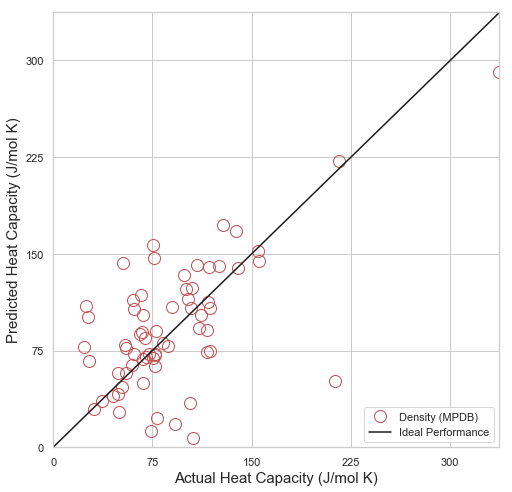

In [48]:
# Plotting the actual data with predicting data
plt.figure(1, figsize=(8,8))
plt.plot(y_test, y_predict, 'ro', markersize=12, mfc='none')
plt.plot([0,1000], [0,1000], 'k')
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))
ticks = np.linspace(0, 300, 5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'])
plt.show()

#### SGDRegressor()

In [49]:
# Create the SGDRegressor model
sgd = SGDRegressor()
%time sgd.fit(X_train, y_train)

Wall time: 38 ms


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [50]:
# Prediction
y_predict = sgd.predict(X_test)
print('Score is:', sgd.score(X_test, y_test))
print('EVS is:', explained_variance_score(y_test,y_predict))
print('MAE is:', mean_absolute_error(y_test, y_predict))
print('MSE is:', mean_squared_error(y_test, y_predict))
print('r2_score is:', r2_score(y_test, y_predict))

Score is: 0.7865360177891362
EVS is: 0.8860636931632386
MAE is: 18.448145350024433
MSE is: 516.72253243903
r2_score is: 0.7865360177891362


(-11.82761823929988, 322.50161277452685)

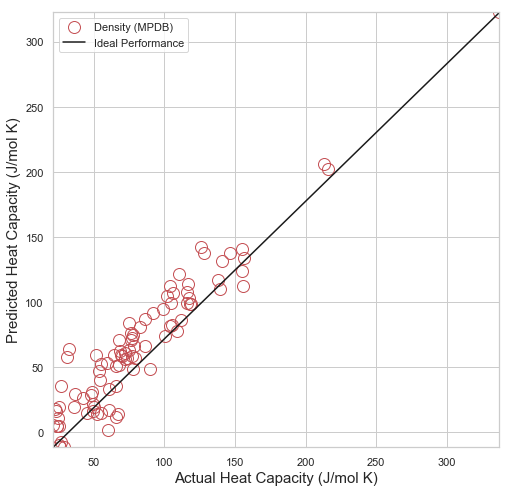

In [51]:
# Plotting the actual data with predicting data
plt.figure(2, figsize=(8,8))
plt.plot(y_test, y_predict, 'ro', markersize=12, mfc='none')
plt.plot([min(y_test), max(y_test)], [min(y_predict), max(y_predict)], 'k')
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
# plt.xlim(0, max(y_test))
# plt.ylim(0, max(y_test))
# ticks = np.linspace(0, 300, 5)
# plt.xticks(ticks)
# plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'])
ax = plt.gca()
ax.set_xlim([min(y_test), max(y_test)])
ax.set_ylim([min(y_predict), max(y_predict)])

#### Lasso()

In [52]:
# Create the Lasso model
lasso = Lasso()
%time lasso.fit(X_train, y_train)

Wall time: 8.01 ms


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [53]:
# Prediction
y_predict = lasso.predict(X_test)
print('Score is:', lasso.score(X_test, y_test))
print('EVS is:', explained_variance_score(y_test,y_predict))
print('MAE is:', mean_absolute_error(y_test, y_predict))
print('MSE is:', mean_squared_error(y_test, y_predict))
print('r2_score is:', r2_score(y_test, y_predict))

Score is: 0.9545538514224974
EVS is: 0.9548522606031179
MAE is: 7.57136598987977
MSE is: 110.00942050903252
r2_score is: 0.9545538514224974


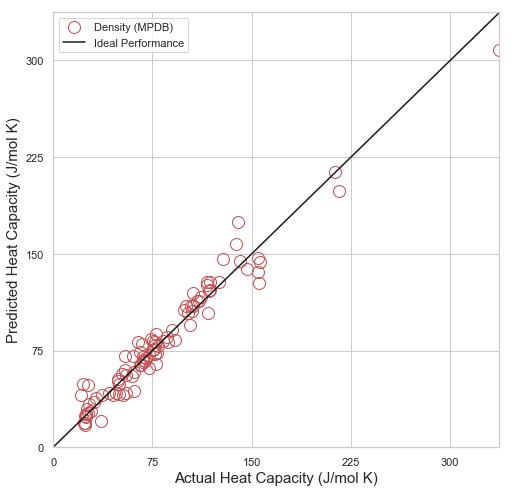

In [54]:
# Plotting the actual data with predicting data
plt.figure(3, figsize=(8,8))
plt.plot(y_test, y_predict, 'ro', markersize=12, mfc='none')
plt.plot([0,1000], [0,1000], 'k')
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))
ticks = np.linspace(0, 300, 5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'])
plt.show()

#### ElasticNet()

In [55]:
# Create the ElasticNet model
elastic = ElasticNet()
%time elastic.fit(X_train, y_train)

Wall time: 4 ms


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [56]:
# Prediction
y_predict = elastic.predict(X_test)
print('Score is:', elastic.score(X_test, y_test))
print('EVS is:', explained_variance_score(y_test,y_predict))
print('MAE is:', mean_absolute_error(y_test, y_predict))
print('MSE is:', mean_squared_error(y_test, y_predict))
print('r2_score is:', r2_score(y_test, y_predict))

Score is: 0.9572986308017282
EVS is: 0.9574557171170484
MAE is: 7.222556051006207
MSE is: 103.3652581677644
r2_score is: 0.9572986308017282


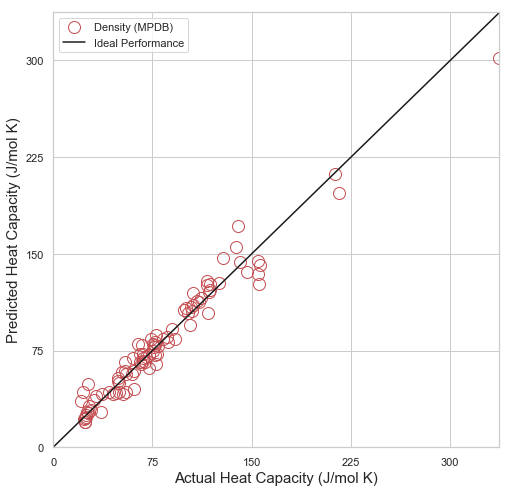

In [57]:
# Plotting the actual data with predicting data
plt.figure(4, figsize=(8,8))
plt.plot(y_test, y_predict, 'ro', markersize=12, mfc='none')
plt.plot([0,1000], [0,1000], 'k')
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))
ticks = np.linspace(0, 300, 5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'])
plt.show()

#### Ridge()

In [58]:
# Create the Ridge model
ridge = Ridge()
%time ridge.fit(X_train, y_train)

Wall time: 28 ms


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [59]:
# Prediction
y_predict = ridge.predict(X_test)
print('Score is:', ridge.score(X_test, y_test))
print('EVS is:', explained_variance_score(y_test,y_predict))
print('MAE is:', mean_absolute_error(y_test, y_predict))
print('MSE is:', mean_squared_error(y_test, y_predict))
print('r2_score is:', r2_score(y_test, y_predict))

Score is: 0.9649031708491113
EVS is: 0.9658275841604912
MAE is: 6.048446617228854
MSE is: 84.95729467612378
r2_score is: 0.9649031708491113


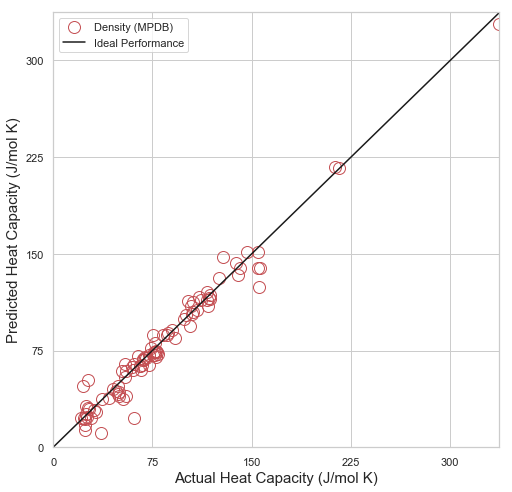

In [60]:
# Plotting the actual data with predicting data
plt.figure(5, figsize=(8,8))
plt.plot(y_test, y_predict, 'ro', markersize=12, mfc='none')
plt.plot([0,1000], [0,1000], 'k')
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))
ticks = np.linspace(0, 300, 5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'])
plt.show()

#### SVR()

In [61]:
# Create the SVR model
svr = SVR()
%time svr.fit(X_train, y_train)

Wall time: 52 ms


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [62]:
# Prediction
y_predict = svr.predict(X_test)
print('Score is:', svr.score(X_test, y_test))
print('EVS is:', explained_variance_score(y_test,y_predict))
print('MAE is:', mean_absolute_error(y_test, y_predict))
print('MSE is:', mean_squared_error(y_test, y_predict))
print('r2_score is:', r2_score(y_test, y_predict))

Score is: 0.1789325399636994
EVS is: 0.1991495628301545
MAE is: 29.198285202816983
MSE is: 1987.5205777532208
r2_score is: 0.1789325399636994


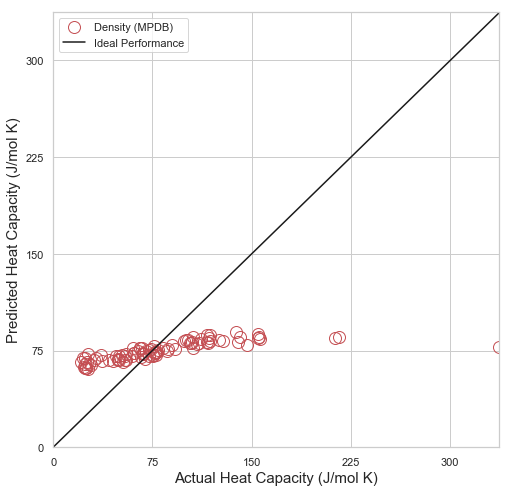

In [63]:
# Plotting the actual data with predicting data
plt.figure(6, figsize=(8,8))
plt.plot(y_test, y_predict, 'ro', markersize=12, mfc='none')
plt.plot([0,1000], [0,1000], 'k')
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))
ticks = np.linspace(0, 300, 5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'])
plt.show()

#### LinearSVR()

In [64]:
# Create the LinearSVR model
linsvr = LinearSVR()
%time linsvr.fit(X_train, y_train)

Wall time: 71.4 ms


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [65]:
# Prediction
y_predict = linsvr.predict(X_test)
print('Score is:', linsvr.score(X_test, y_test))
print('EVS is:', explained_variance_score(y_test,y_predict))
print('MAE is:', mean_absolute_error(y_test, y_predict))
print('MSE is:', mean_squared_error(y_test, y_predict))
print('r2_score is:', r2_score(y_test, y_predict))

Score is: 0.9626953838030688
EVS is: 0.970635770554337
MAE is: 6.332421127498344
MSE is: 90.30158415157346
r2_score is: 0.9626953838030688


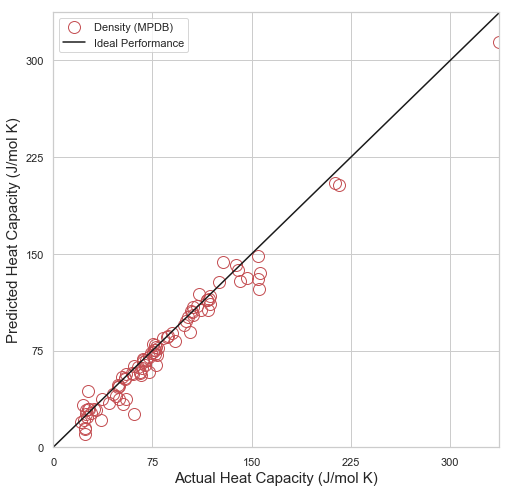

In [66]:
# Plotting the actual data with predicting data
plt.figure(7, figsize=(8,8))
plt.plot(y_test, y_predict, 'ro', markersize=12, mfc='none')
plt.plot([0,1000], [0,1000], 'k')
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))
ticks = np.linspace(0, 300, 5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'])
plt.show()

#### BaggingRegressor()

In [67]:
# Create the BaggingRegressor model
bagreg = BaggingRegressor()
%time bagreg.fit(X_train, y_train)

Wall time: 189 ms


BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [68]:
# Prediction
y_predict = bagreg.predict(X_test)
print('Score is:', bagreg.score(X_test, y_test))
print('EVS is:', explained_variance_score(y_test,y_predict))
print('MAE is:', mean_absolute_error(y_test, y_predict))
print('MSE is:', mean_squared_error(y_test, y_predict))
print('r2_score is:', r2_score(y_test, y_predict))

Score is: 0.810338892996585
EVS is: 0.8117843539171392
MAE is: 13.044377173913043
MSE is: 459.10399731597823
r2_score is: 0.810338892996585


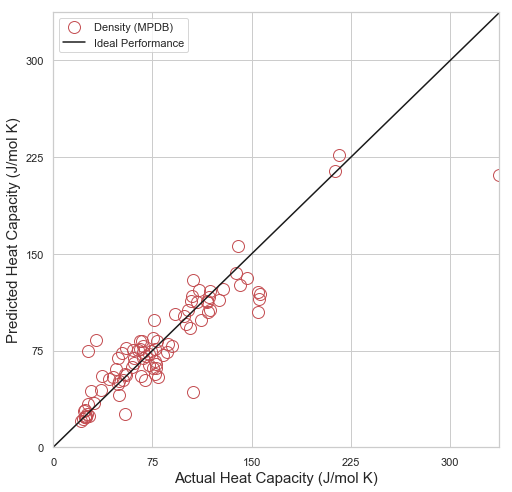

In [69]:
# Plotting the actual data with predicting data
plt.figure(8, figsize=(8,8))
plt.plot(y_test, y_predict, 'ro', markersize=12, mfc='none')
plt.plot([0,1000], [0,1000], 'k')
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))
ticks = np.linspace(0, 300, 5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'])
plt.show()

#### RandomForestRegressor()

In [70]:
# Create the RandomForestRegressor() model
rfreg = RandomForestRegressor()
%time rfreg.fit(X_train, y_train)

Wall time: 181 ms


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [71]:
# Prediction
y_predict = rfreg.predict(X_test)
print('Score is:', rfreg.score(X_test, y_test))
print('EVS is:', explained_variance_score(y_test,y_predict))
print('MAE is:', mean_absolute_error(y_test, y_predict))
print('MSE is:', mean_squared_error(y_test, y_predict))
print('r2_score is:', r2_score(y_test, y_predict))

Score is: 0.8348729377367577
EVS is: 0.8368938278248628
MAE is: 12.718284782608698
MSE is: 399.7155534304349
r2_score is: 0.8348729377367577


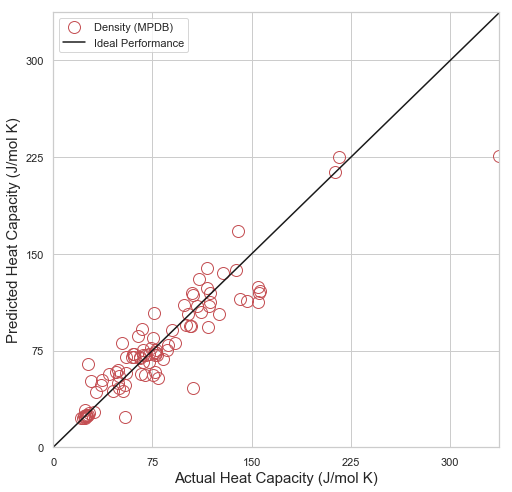

In [72]:
# Plotting the actual data with predicting data
plt.figure(9, figsize=(8,8))
plt.plot(y_test, y_predict, 'ro', markersize=12, mfc='none')
plt.plot([0,1000], [0,1000], 'k')
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))
ticks = np.linspace(0, 300, 5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'])
plt.show()

#### KNeighborsRegressor()

In [73]:
# Create the KNeighborsRegressor() model
knreg = KNeighborsRegressor(n_neighbors=5)
%time knreg.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [74]:
# Prediction
y_predict = knreg.predict(X_test)
print('Score is:', knreg.score(X_test, y_test))
print('EVS is:', explained_variance_score(y_test,y_predict))
print('MAE is:', mean_absolute_error(y_test, y_predict))
print('MSE is:', mean_squared_error(y_test, y_predict))
print('r2_score is:', r2_score(y_test, y_predict))

Score is: 0.8278705057593801
EVS is: 0.8308915618522215
MAE is: 13.341182608695652
MSE is: 416.66602136
r2_score is: 0.8278705057593803


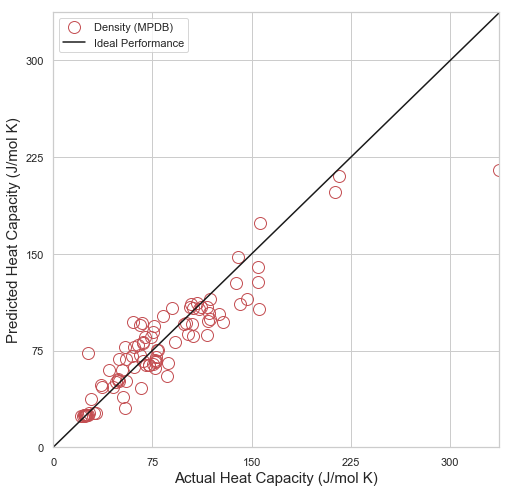

In [75]:
# Plotting the actual data with predicting data
plt.figure(10, figsize=(8,8))
plt.plot(y_test, y_predict, 'ro', markersize=12, mfc='none')
plt.plot([0,1000], [0,1000], 'k')
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))
ticks = np.linspace(0, 300, 5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'])
plt.show()

#### DecisionTreeRegressor()

In [76]:
# Create the DecisionTreeRegressor() model
dtreg = DecisionTreeRegressor()
%time dtreg.fit(X_train, y_train)

Wall time: 36 ms


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [77]:
# Prediction
y_predict = dtreg.predict(X_test)
print('Score is:', dtreg.score(X_test, y_test))
print('EVS is:', explained_variance_score(y_test,y_predict))
print('MAE is:', mean_absolute_error(y_test, y_predict))
print('MSE is:', mean_squared_error(y_test, y_predict))
print('r2_score is:', r2_score(y_test, y_predict))

Score is: 0.6252070105125266
EVS is: 0.6257475718465549
MAE is: 17.707771739130436
MSE is: 907.2443072717392
r2_score is: 0.6252070105125267


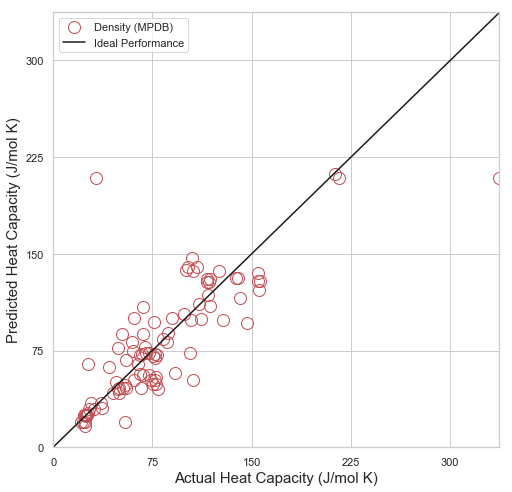

In [78]:
# Plotting the actual data with predicting data
plt.figure(11, figsize=(8,8))
plt.plot(y_test, y_predict, 'ro', markersize=12, mfc='none')
plt.plot([0,1000], [0,1000], 'k')
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))
ticks = np.linspace(0, 300, 5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'])
plt.show()

#### MLPRegressor()

In [79]:
# Create the MLPRegressor() model
mlpreg = MLPRegressor()
%time mlpreg.fit(X_train, y_train)

Wall time: 1.18 s


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [80]:
# Prediction
y_predict = mlpreg.predict(X_test)
print('Score is:', mlpreg.score(X_test, y_test))
print('EVS is:', explained_variance_score(y_test,y_predict))
print('MAE is:', mean_absolute_error(y_test, y_predict))
print('MSE is:', mean_squared_error(y_test, y_predict))
print('r2_score is:', r2_score(y_test, y_predict))

Score is: -0.6168756288479708
EVS is: 0.5730036800466476
MAE is: 53.66830172935827
MSE is: 3913.897140511383
r2_score is: -0.6168756288479706


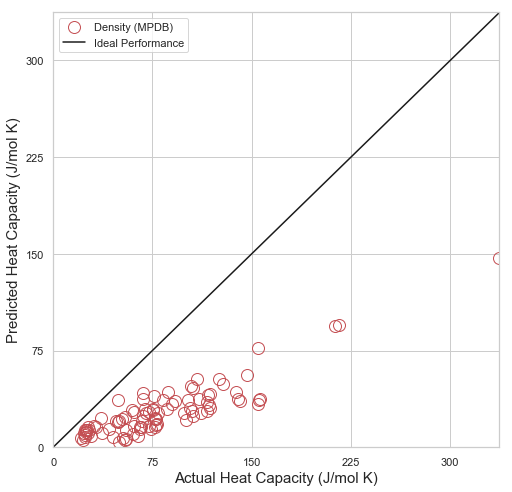

In [81]:
# Plotting the actual data with predicting data
plt.figure(12, figsize=(8,8))
plt.plot(y_test, y_predict, 'ro', markersize=12, mfc='none')
plt.plot([0,1000], [0,1000], 'k')
plt.xlabel('Actual Heat Capacity (J/mol K)', fontsize=15)
plt.ylabel('Predicted Heat Capacity (J/mol K)', fontsize=15)
plt.xlim(0, max(y_test))
plt.ylim(0, max(y_test))
ticks = np.linspace(0, 300, 5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.legend(['Density (MPDB)','Ideal Performance'])
plt.show()

### 9-2: GridSearchCV

**GridSearchCV** should be used to find the **optimal parameters** to train your final model. Typically, you should run GridSearchCV then look at the parameters that gave the model with the best score. You should then take these parameters and train your final model on all of the data. It is important to note that if you have trained your final model on all of your data, you cannot test it. For any correct test, you must must reserve some of the data.

In [82]:
# For cross validation purpose, we should put both the data and targets in the lists
X = df_pca
y = ser_targets.values

#### LinearRegression()

In [83]:
# Create the LinearRegression() model
linreg = LinearRegression()
linreg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [84]:
# Create a parameter grid
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

# Instantiate the GridSearchCV
grid = GridSearchCV(linreg, param_grid, cv=10)

# Fit the grid with data
%time grid.fit(X, y)

Wall time: 2.32 s


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [85]:
# View the results as a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\util

,mean_test_score,std_test_score,params
0,-7.396548e+24,8.461008e+24,"{'copy_X': True, 'fit_intercept': True, 'norma..."
1,-1.030250e+21,9.226644e+20,"{'copy_X': True, 'fit_intercept': True, 'norma..."
2,-1.073244e+20,1.793568e+20,"{'copy_X': True, 'fit_intercept': False, 'norm..."
3,-1.073244e+20,1.793568e+20,"{'copy_X': True, 'fit_intercept': False, 'norm..."
4,-7.396548e+24,8.461008e+24,"{'copy_X': False, 'fit_intercept': True, 'norm..."
5,-1.030250e+21,9.226644e+20,"{'copy_X': False, 'fit_intercept': True, 'norm..."
6,-1.073244e+20,1.793568e+20,"{'copy_X': False, 'fit_intercept': False, 'nor..."
7,-1.073244e+20,1.793568e+20,"{'copy_X': False, 'fit_intercept': False, 'nor..."


In [86]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-1.0732442385396897e+20
{'copy_X': True, 'fit_intercept': False, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=True)


#### SGDRegressor()

In [87]:
# Create the SGDRegressor() model
sgd = SGDRegressor()
sgd.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': None,
 'n_iter': None,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': None,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [88]:
# Create a parameter grid
param_grid = {'alpha':[0.0001,0.001,0.01], 'epsilon':[0.01,0.1,0.2]}

# Instantiate the GridSearchCV
grid = GridSearchCV(sgd, param_grid, cv=10)

# Fit the grid with data
%time grid.fit(X, y)

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 a

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 a

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 a

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 a

Wall time: 660 ms


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 a

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01], 'epsilon': [0.01, 0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [89]:
# View the results as a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\util

,mean_test_score,std_test_score,params
0,-0.780464,2.996254,"{'alpha': 0.0001, 'epsilon': 0.01}"
1,-0.039651,1.817414,"{'alpha': 0.0001, 'epsilon': 0.1}"
2,-0.104746,2.137713,"{'alpha': 0.0001, 'epsilon': 0.2}"
3,-0.000551,1.803917,"{'alpha': 0.001, 'epsilon': 0.01}"
4,-0.157694,2.269780,"{'alpha': 0.001, 'epsilon': 0.1}"
5,-0.015119,1.943052,"{'alpha': 0.001, 'epsilon': 0.2}"
6,-0.269821,2.318795,"{'alpha': 0.01, 'epsilon': 0.01}"
7,0.028939,1.692991,"{'alpha': 0.01, 'epsilon': 0.1}"
8,0.028935,1.674581,"{'alpha': 0.01, 'epsilon': 0.2}"


In [90]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.02893899696998216
{'alpha': 0.01, 'epsilon': 0.1}
SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)


#### Lasso()

In [91]:
# Create the Lasso() model
lasso = Lasso()
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [92]:
# Create a parameter grid
param_grid = {'alpha':[1.0,2.0,10.0]}

# Instantiate the GridSearchCV
grid = GridSearchCV(lasso, param_grid, cv=10)

# Fit the grid with data
%time grid.fit(X, y)

Wall time: 190 ms


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1.0, 2.0, 10.0]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [93]:
# View the results as a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\util

,mean_test_score,std_test_score,params
0,0.924352,0.035700,{'alpha': 1.0}
1,0.912840,0.045545,{'alpha': 2.0}
2,0.884480,0.068456,{'alpha': 10.0}


In [94]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9243519856824224
{'alpha': 1.0}
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


#### ElasticNet()

In [95]:
# Create the ElasticNet() model
elastic = ElasticNet()
elastic.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [96]:
# Create a parameter grid
param_grid = {'alpha':[0.1,1.0,2.0,10.0]}

# Instantiate the GridSearchCV
grid = GridSearchCV(elastic, param_grid, cv=10)

# Fit the grid with data
%time grid.fit(X, y)

Wall time: 256 ms


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 1.0, 2.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [97]:
# View the results as a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\util

,mean_test_score,std_test_score,params
0,0.922561,0.043550,{'alpha': 0.1}
1,0.924306,0.036601,{'alpha': 1.0}
2,0.914100,0.045734,{'alpha': 2.0}
3,0.874002,0.078608,{'alpha': 10.0}


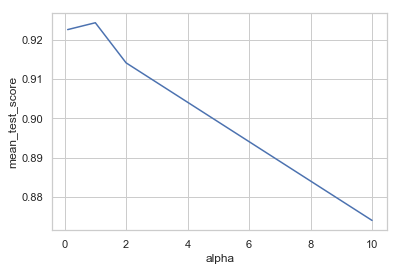

In [98]:
# Plot the results
plt.plot([0.1,1.0,2.0,10.0], grid.cv_results_['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('mean_test_score')
plt.show()

In [99]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9243063623414893
{'alpha': 1.0}
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


#### Ridge()

In [100]:
# Create the Ridge() model
ridge = Ridge()
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [101]:
# Create a parameter grid
param_grid = {'alpha':[0.1,1.0,2.0,10.0], 'tol':[0.0001,0.001,0.01]}

# Instantiate the GridSearchCV
grid = GridSearchCV(ridge, param_grid, cv=10)

# Fit the grid with data
%time grid.fit(X, y)

Wall time: 1.23 s


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 1.0, 2.0, 10.0], 'tol': [0.0001, 0.001, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [102]:
# View the results as a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\util

,mean_test_score,std_test_score,params
0,0.847545,0.145403,"{'alpha': 0.1, 'tol': 0.0001}"
1,0.847545,0.145403,"{'alpha': 0.1, 'tol': 0.001}"
2,0.847545,0.145403,"{'alpha': 0.1, 'tol': 0.01}"
3,0.883319,0.122312,"{'alpha': 1.0, 'tol': 0.0001}"
4,0.883319,0.122312,"{'alpha': 1.0, 'tol': 0.001}"
5,0.883319,0.122312,"{'alpha': 1.0, 'tol': 0.01}"
6,0.894192,0.099821,"{'alpha': 2.0, 'tol': 0.0001}"
7,0.894192,0.099821,"{'alpha': 2.0, 'tol': 0.001}"
8,0.894192,0.099821,"{'alpha': 2.0, 'tol': 0.01}"
9,0.918321,0.052195,"{'alpha': 10.0, 'tol': 0.0001}"


In [103]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9183212130087618
{'alpha': 10.0, 'tol': 0.0001}
Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.0001)


#### SVR()

In [104]:
# Create the SVR() model
svr = SVR()
svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [105]:
# Create a parameter grid
param_grid = {'C':[0.1,1.0,2.0], 'epsilon':[0.01,0.1,0.5], 'tol':[0.001,0.005,0.1]}

# Instantiate the GridSearchCV
grid = GridSearchCV(svr, param_grid, cv=10)

# Fit the grid with data
%time grid.fit(X, y)

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

Wall time: 19.8 s


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1.0, 2.0], 'epsilon': [0.01, 0.1, 0.5], 'tol': [0.001, 0.005, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [106]:
# View the results as a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\util

,mean_test_score,std_test_score,params
0,-0.080725,0.170335,"{'C': 0.1, 'epsilon': 0.01, 'tol': 0.001}"
1,-0.080725,0.170335,"{'C': 0.1, 'epsilon': 0.01, 'tol': 0.005}"
2,-0.080957,0.170829,"{'C': 0.1, 'epsilon': 0.01, 'tol': 0.1}"
3,-0.080856,0.170601,"{'C': 0.1, 'epsilon': 0.1, 'tol': 0.001}"
4,-0.080856,0.170601,"{'C': 0.1, 'epsilon': 0.1, 'tol': 0.005}"
5,-0.080845,0.170608,"{'C': 0.1, 'epsilon': 0.1, 'tol': 0.1}"
6,-0.082333,0.172874,"{'C': 0.1, 'epsilon': 0.5, 'tol': 0.001}"
7,-0.082333,0.172874,"{'C': 0.1, 'epsilon': 0.5, 'tol': 0.005}"
8,-0.082330,0.172873,"{'C': 0.1, 'epsilon': 0.5, 'tol': 0.1}"
9,0.216672,0.177749,"{'C': 1.0, 'epsilon': 0.01, 'tol': 0.001}"


In [107]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.4174829899177821
{'C': 2.0, 'epsilon': 0.01, 'tol': 0.1}
SVR(C=2.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.01,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.1, verbose=False)


#### LinearSVR()

In [108]:
# Create the LinearSVR() model
linsvr = LinearSVR()
linsvr.get_params()

{'C': 1.0,
 'dual': True,
 'epsilon': 0.0,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'loss': 'epsilon_insensitive',
 'max_iter': 1000,
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [109]:
# Create a parameter grid
param_grid = {'C':[0.1,1.0,2.0], 'max_iter':[100,1000,5000], 'tol':[0.0001,0.001]}

# Instantiate the GridSearchCV
grid = GridSearchCV(linsvr, param_grid, cv=10)

# Fit the grid with data
%time grid.fit(X, y)

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Wall time: 13.4 s


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1.0, 2.0], 'max_iter': [100, 1000, 5000], 'tol': [0.0001, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [110]:
# View the results as a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\util

,mean_test_score,std_test_score,params
0,-8.153917,4.752679,"{'C': 0.1, 'max_iter': 100, 'tol': 0.0001}"
1,-8.152658,4.746509,"{'C': 0.1, 'max_iter': 100, 'tol': 0.001}"
2,-8.152092,4.753019,"{'C': 0.1, 'max_iter': 1000, 'tol': 0.0001}"
3,-8.143267,4.734157,"{'C': 0.1, 'max_iter': 1000, 'tol': 0.001}"
4,-8.154487,4.755633,"{'C': 0.1, 'max_iter': 5000, 'tol': 0.0001}"
5,-8.160235,4.740183,"{'C': 0.1, 'max_iter': 5000, 'tol': 0.001}"
6,0.744528,0.482637,"{'C': 1.0, 'max_iter': 100, 'tol': 0.0001}"
7,0.744003,0.484848,"{'C': 1.0, 'max_iter': 100, 'tol': 0.001}"
8,0.743483,0.485583,"{'C': 1.0, 'max_iter': 1000, 'tol': 0.0001}"
9,0.743463,0.484637,"{'C': 1.0, 'max_iter': 1000, 'tol': 0.001}"


In [111]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8046926797640168
{'C': 2.0, 'max_iter': 100, 'tol': 0.0001}
LinearSVR(C=2.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=100,
     random_state=None, tol=0.0001, verbose=0)


#### BaggingRegressor()

In [112]:
# Create the BaggingRegressor() model
bagreg = BaggingRegressor()
bagreg.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [113]:
# Create a parameter grid
param_grid = {'n_estimators':[5,10,20]}

# Instantiate the GridSearchCV
grid = GridSearchCV(bagreg, param_grid, cv=10)

# Fit the grid with data
%time grid.fit(X, y)

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 12.3 s


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 20]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [114]:
# View the results as a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\util

,mean_test_score,std_test_score,params
0,0.651906,0.312409,{'n_estimators': 5}
1,0.752474,0.175493,{'n_estimators': 10}
2,0.775803,0.136058,{'n_estimators': 20}


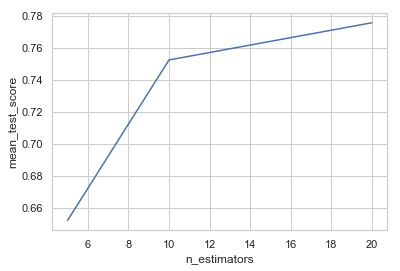

In [115]:
# Plot the results
plt.plot([5,10,20], grid.cv_results_['mean_test_score'])
plt.xlabel('n_estimators')
plt.ylabel('mean_test_score')
plt.show()

In [116]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7758032058855396
{'n_estimators': 20}
BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=20, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)


#### RandomForestRegressor()

In [117]:
# Create the RandomForestRegressor() model
rfreg = RandomForestRegressor()
rfreg.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [118]:
# Create a parameter grid
param_grid = {'n_estimators':[5,20,100]}

# Instantiate the GridSearchCV
grid = GridSearchCV(rfreg, param_grid, cv=10)

# Fit the grid with data
%time grid.fit(X, y)

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 36.8 s


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 20, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [119]:
# View the results as a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\util

,mean_test_score,std_test_score,params
0,0.771618,0.096879,{'n_estimators': 5}
1,0.790219,0.094981,{'n_estimators': 20}
2,0.786247,0.119496,{'n_estimators': 100}


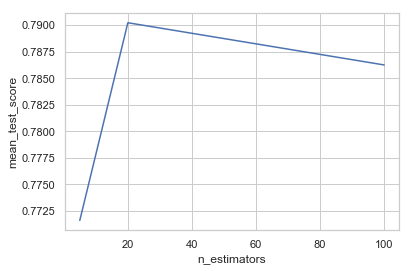

In [120]:
# Plot the results
plt.plot([5,20,100], grid.cv_results_['mean_test_score'])
plt.xlabel('n_estimators')
plt.ylabel('mean_test_score')
plt.show()

In [121]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.790218619299727
{'n_estimators': 20}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


#### KNeighborsRegressor()

In [122]:
# Create the KNeighborsRegressor() model
knreg = KNeighborsRegressor()
knreg.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [123]:
# Create a parameter grid
param_grid = {'leaf_size':[10,30,50], 'n_neighbors':[5,10]}

# Instantiate the GridSearchCV
grid = GridSearchCV(knreg, param_grid, cv=10)

# Fit the grid with data
%time grid.fit(X, y)

Wall time: 3.35 s


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'leaf_size': [10, 30, 50], 'n_neighbors': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [124]:
# View the results as a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\util

,mean_test_score,std_test_score,params
0,0.647651,0.191914,"{'leaf_size': 10, 'n_neighbors': 5}"
1,0.666659,0.162514,"{'leaf_size': 10, 'n_neighbors': 10}"
2,0.647651,0.191914,"{'leaf_size': 30, 'n_neighbors': 5}"
3,0.666659,0.162514,"{'leaf_size': 30, 'n_neighbors': 10}"
4,0.647651,0.191914,"{'leaf_size': 50, 'n_neighbors': 5}"
5,0.666659,0.162514,"{'leaf_size': 50, 'n_neighbors': 10}"


In [125]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6666590328932278
{'leaf_size': 10, 'n_neighbors': 10}
KNeighborsRegressor(algorithm='auto', leaf_size=10, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')


#### DecisionTreeRegressor()

In [126]:
# Create the DecisionTreeRegressor() model
treereg = DecisionTreeRegressor()
treereg.get_params()

{'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [127]:
# Create a parameter grid
param_grid = {'min_samples_leaf':[1,2,10], 'min_samples_split':[0.5,2,10]}

# Instantiate the GridSearchCV
grid = GridSearchCV(treereg, param_grid, cv=10)

# Fit the grid with data
%time grid.fit(X, y)

Wall time: 3.13 s


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': [1, 2, 10], 'min_samples_split': [0.5, 2, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [128]:
# View the results as a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\util

,mean_test_score,std_test_score,params
0,0.264555,0.545343,"{'min_samples_leaf': 1, 'min_samples_split': 0.5}"
1,0.377112,0.707129,"{'min_samples_leaf': 1, 'min_samples_split': 2}"
2,0.430220,0.608591,"{'min_samples_leaf': 1, 'min_samples_split': 10}"
3,0.264555,0.545343,"{'min_samples_leaf': 2, 'min_samples_split': 0.5}"
4,0.393061,0.700309,"{'min_samples_leaf': 2, 'min_samples_split': 2}"
5,0.454020,0.565427,"{'min_samples_leaf': 2, 'min_samples_split': 10}"
6,0.241888,0.525860,"{'min_samples_leaf': 10, 'min_samples_split': ..."
7,0.437392,0.596337,"{'min_samples_leaf': 10, 'min_samples_split': 2}"
8,0.436084,0.595719,"{'min_samples_leaf': 10, 'min_samples_split': 10}"


In [129]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.4540200657365576
{'min_samples_leaf': 2, 'min_samples_split': 10}
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


#### MLPRegressor()

In [130]:
# Create the MLPRegressor() model
mlpreg = MLPRegressor()
mlpreg.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [131]:
# Create a parameter grid
param_grid = {'alpha':[0.0001,0.01], 'learning_rate_init':[0.0001,0.0005,0.001]}

# Instantiate the GridSearchCV
grid = GridSearchCV(mlpreg, param_grid, cv=10)

# Fit the grid with data
%time grid.fit(X, y)

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

Wall time: 1min 55s


C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.01], 'learning_rate_init': [0.0001, 0.0005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [132]:
# View the results as a DataFrame
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\alisa\Anaconda3\lib\site-packages\sklearn\util

,mean_test_score,std_test_score,params
0,-4.493365,2.203892,"{'alpha': 0.0001, 'learning_rate_init': 0.0001}"
1,-2.342148,1.533176,"{'alpha': 0.0001, 'learning_rate_init': 0.0005}"
2,-0.152362,0.522981,"{'alpha': 0.0001, 'learning_rate_init': 0.001}"
3,-4.473595,2.210203,"{'alpha': 0.01, 'learning_rate_init': 0.0001}"
4,-2.329107,1.382401,"{'alpha': 0.01, 'learning_rate_init': 0.0005}"
5,-0.224945,0.524514,"{'alpha': 0.01, 'learning_rate_init': 0.001}"


In [133]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

-0.1523618899091427
{'alpha': 0.0001, 'learning_rate_init': 0.001}
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


# 10: Prediction by Deep Learning Methods

### 10-1: Fully Connected Neural Network (FCN) with Unstandardzied Data

In [145]:
# Define base model
def baseline_model():
    # Create model
    model = Sequential()
    model.add(Dense(228, input_dim=228, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [146]:
# Create the KerasRegressor estimator
kerasreg = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [149]:
# Using Unstandardized data
X = df_features.values
y = ser_targets

In [150]:
# Evaluate model
kfold = KFold(n_splits=10)
results = cross_val_score(kerasreg, X, y, cv=kfold)
print('Results: %.2f (%.2f) MSE' % (results.mean(), results.std()))

Results: -138973040.51 (149046280.58) MSE


### 10-2: Fully Connected Neural Network (FCN) with Standardzied Data

In [151]:
# Evaluate model
estimator = []
estimator.append(('standardize', StandardScaler()))
estimator.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimator)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, y, cv=kfold)
print('Results: %.2f (%.2f) MSE' % (results.mean(), results.std()))

Results: -127.74 (40.48) MSE


### 10-3: Fully Connected Neural Network (FCN) with More Layers

In [159]:
def larger_model():
    # Create model
    model = Sequential()
    model.add(Dense(114, input_dim=228, kernel_initializer='normal', activation='relu'))
    model.add(Dense(228, kernel_initializer='normal', activation='relu'))
    model.add(Dense(228, kernel_initializer='normal', activation='relu'))
    model.add(Dense(228, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [160]:
# Evaluate model
estimator = []
estimator.append(('standardize', StandardScaler()))
estimator.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimator)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, y, cv=kfold)
print('Results: %.2f (%.2f) MSE' % (results.mean(), results.std()))

Results: -155.97 (50.19) MSE


### 10-4: Fully Connected Neural Network (FCN) with More Nodes

In [155]:
def wider_model():
    # Create model
    model = Sequential()
    model.add(Dense(428, input_dim=228, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [156]:
# Evaluate model
estimator = []
estimator.append(('standardize', StandardScaler()))
estimator.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimator)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, y, cv=kfold)
print('Results: %.2f (%.2f) MSE' % (results.mean(), results.std()))

Results: -155.16 (72.81) MSE
